In [71]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import sklearn
print(sklearn.__version__)

1.6.1


In [72]:
match = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

In [73]:
total_score_df = (
    delivery.groupby(['match_id', 'inning'])
    .sum()['total_runs']
    .reset_index()
)

first_innings = total_score_df[total_score_df['inning'] == 1]

In [74]:
#total_score_df

In [75]:
match_df = match.merge(
    first_innings[['match_id', 'total_runs']],
    left_on='id', right_on='match_id'
)

In [76]:
#match_df

In [77]:
teams = [
'Royal Challengers Bengaluru', 'Mumbai Indians', 'Kolkata Knight Riders',
'Rajasthan Royals', 'Chennai Super Kings', 'Sunrisers Hyderabad',
'Lucknow Super Giants', 'Gujarat Titans', 'Punjab Kings', 'Delhi Capitals'
]

In [78]:
match_df = match_df[['match_id', 'city', 'winner', 'total_runs']]


In [79]:
delivery_df = match_df.merge(delivery, on='match_id')
delivery_df = delivery_df[delivery_df['inning'] == 2]

In [80]:
#delivery_df

In [ ]:
# Current score
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()

# Balls left
delivery_df['balls_left'] = 120 - (delivery_df['over'] * 6 + delivery_df['ball'])

# Wickets
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x: "0" if x=="0" else "1")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype(int)

wickets_fallen = delivery_df.groupby('match_id')['player_dismissed'].cumsum()
delivery_df['wickets'] = 10 - wickets_fallen

delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']

# CRR
delivery_df['crr'] = delivery_df['current_score'] / ((120 - delivery_df['balls_left'])/6 + 1e-9)

# RRR (avoid division by zero)
delivery_df['rrr'] = np.where(
    delivery_df['balls_left'] == 0,
    0,
    (delivery_df['runs_left'] * 6) / delivery_df['balls_left']
)


In [82]:
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

delivery_df['result'] = delivery_df.apply(result, axis=1)

In [83]:
from sklearn.model_selection import train_test_split

# Train-test split based on match_id
train_matches, test_matches = train_test_split(
    delivery_df['match_id'].unique(), test_size=0.2, random_state=42
)

train_df = delivery_df[delivery_df['match_id'].isin(train_matches)]
test_df  = delivery_df[delivery_df['match_id'].isin(test_matches)]


In [84]:
final_df = delivery_df[
    ['batting_team', 'bowling_team', 'city',
     'runs_left', 'balls_left', 'wickets',
     'total_runs_x', 'crr', 'rrr', 'result']
]

final_df.dropna(inplace=True)
final_df = final_df[final_df['balls_left'] != 0]
final_df = final_df.sample(frac=1).reset_index(drop=True)

/var/folders/xb/h0lk3sv17rd9yrw9050cxpyc0000gp/T/ipykernel_51461/2896665759.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.dropna(inplace=True)


In [85]:
#print(final_df)

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check class balance
# sns.countplot(x='result', data=final_df)
# plt.title("Win/Loss distribution")
# plt.show()

In [87]:
X = final_df.drop('result', axis=1)
y = final_df['result']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

In [88]:
categorical_cols = ['batting_team', 'bowling_team', 'city']

trf = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
], remainder='passthrough')

from sklearn.linear_model import LogisticRegression

pipe = Pipeline(steps=[
    ('transform', trf),
    ('model', LogisticRegression(solver='liblinear'))
])

pipe.fit(X_train, y_train)

# Predictions
y_train_pred_lr = pipe.predict(X_train)
y_test_pred_lr  = pipe.predict(X_test)

# Probabilities
y_train_proba_lr = pipe.predict_proba(X_train)[:, 1]
y_test_proba_lr  = pipe.predict_proba(X_test)[:, 1]


In [89]:
print("Accuracy:", accuracy_score(y_test, y_test_pred_lr))
print("F1 Score:", f1_score(y_test, y_test_pred_lr))
print("Recall:", recall_score(y_test, y_test_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_lr))


Accuracy: 0.8145323499832383
F1 Score: 0.8248377394332753
Recall: 0.8324147296109913
ROC-AUC: 0.8972316208934917


In [90]:
pipe.predict_proba(X_test)[12]

array([0.48647032, 0.51352968])

# Tabnet

In [91]:
!pip install pytorch-tabnet --quiet

In [92]:
# CHUNK 1 — PREPARE DATA
df = final_df.copy().reset_index(drop=True)

X = df.drop('result', axis=1)
y = df['result'].astype(int)

# Label Encoding
cat_cols = ['batting_team', 'bowling_team', 'city']
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

# Convert to numpy (TabNet needs float32)
X_np = X.values.astype(np.float32)
y_np = y.values.astype(np.int64)

# Train/Test split
X_train_tab, X_test_tab, y_train_tab, y_test_tab = train_test_split(
    X_np, y_np, test_size=0.2, random_state=1, stratify=y_np
)

print("Train Shape:", X_train_tab.shape)
print("Test Shape:", X_test_tab.shape)

Train Shape: (95453, 9)
Test Shape: (23864, 9)


In [93]:
# CHUNK 2 — TABNET MODEL TRAINING
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type='sparsemax',
    device_name=device
)

clf.fit(
    X_train_tab, y_train_tab,
    eval_set=[(X_test_tab, y_test_tab)],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=55,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128
)

Device: cpu


/opt/anaconda3/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71423 | valid_accuracy: 0.60434 |  0:00:01s
epoch 1  | loss: 0.52497 | valid_accuracy: 0.72368 |  0:00:02s
epoch 2  | loss: 0.4864  | valid_accuracy: 0.76802 |  0:00:03s
epoch 3  | loss: 0.47052 | valid_accuracy: 0.77736 |  0:00:04s
epoch 4  | loss: 0.46305 | valid_accuracy: 0.78306 |  0:00:05s
epoch 5  | loss: 0.45273 | valid_accuracy: 0.78667 |  0:00:06s
epoch 6  | loss: 0.44842 | valid_accuracy: 0.78759 |  0:00:07s
epoch 7  | loss: 0.44184 | valid_accuracy: 0.79123 |  0:00:08s
epoch 8  | loss: 0.43993 | valid_accuracy: 0.79245 |  0:00:09s
epoch 9  | loss: 0.43593 | valid_accuracy: 0.7945  |  0:00:10s
epoch 10 | loss: 0.43384 | valid_accuracy: 0.79589 |  0:00:12s
epoch 11 | loss: 0.43043 | valid_accuracy: 0.79832 |  0:00:13s
epoch 12 | loss: 0.4291  | valid_accuracy: 0.79924 |  0:00:14s
epoch 13 | loss: 0.42733 | valid_accuracy: 0.79852 |  0:00:15s
epoch 14 | loss: 0.42272 | valid_accuracy: 0.79425 |  0:00:16s
epoch 15 | loss: 0.42138 | valid_accuracy: 0.80075 |  0

/opt/anaconda3/lib/python3.13/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [106]:
# CHUNK 3 — METRICS AFTER TRAINING
# Probabilities for ROC-AUC
proba_tab = clf.predict_proba(X_test_tab)[:, 1]

# Predictions from threshold
pred_tab = (proba_tab >= 0.5).astype(int)


# MUST RUN THIS BEFORE evaluate_model()

pred_tab_train = clf.predict(X_train_tab)
pred_tab_test  = clf.predict(X_test_tab)

pred_tab_train_proba = clf.predict_proba(X_train_tab)[:, 1]
pred_tab_test_proba  = clf.predict_proba(X_test_tab)[:, 1]

print("TabNet Accuracy :", accuracy_score(y_test_tab, pred_tab))
print("TabNet F1 Score :", f1_score(y_test_tab, pred_tab))
print("TabNet Recall   :", recall_score(y_test_tab, pred_tab))
print("TabNet ROC-AUC  :", roc_auc_score(y_test_tab, proba_tab))

TabNet Accuracy : 0.8434461951055984
TabNet F1 Score : 0.8519223147047166
TabNet Recall   : 0.8602417353718083
TabNet ROC-AUC  : 0.9317663516404292


In [96]:
proba_tab = clf.predict_proba(X_test_tab)[12]
pred_tab = (proba_tab >= 0.5).astype(int)
proba_tab

array([0.02908538, 0.9709146 ], dtype=float32)

In [97]:
# CHUNK 1 — IMPORTS FOR SVM

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    roc_auc_score
)


In [98]:
# CHUNK 2 — SCALING FOR SVM

scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_tab)
X_test_svm  = scaler.transform(X_test_tab)


In [99]:
# CHUNK 3 — TRAIN SVM

svm = SVC(kernel='rbf', probability=True, random_state=42)

svm.fit(X_train_svm, y_train_tab)


SVC(probability=True, random_state=42)

In [100]:
# CHUNK 4 — SVM METRICS
# Predictions
y_train_pred_svm = svm.predict(X_train_svm)
y_test_pred_svm  = svm.predict(X_test_svm)

# Probabilities (needed for ROC-AUC)
y_train_proba_svm = svm.predict_proba(X_train_svm)[:, 1]
y_test_proba_svm  = svm.predict_proba(X_test_svm)[:, 1]

# Evaluation
print("SVM Accuracy :", accuracy_score(y_test_tab, y_test_pred_svm))
print("SVM F1 Score :", f1_score(y_test_tab, y_test_pred_svm))
print("SVM Recall   :", recall_score(y_test_tab, y_test_pred_svm))
print("SVM ROC-AUC  :", roc_auc_score(y_test_tab, y_test_proba_svm))

SVM Accuracy : 0.8262236004022796
SVM F1 Score : 0.8394937492742965
SVM Recall   : 0.8680861282318099
SVM ROC-AUC  : 0.9102283982046392


In [101]:
# CHUNK 5 — TRAIN / TEST ACCURACY
print("SVM TRAIN Accuracy:", accuracy_score(y_train_tab, y_train_pred_svm))
print("SVM TEST  Accuracy:", accuracy_score(y_test_tab, y_test_pred_svm))

SVM TRAIN Accuracy: 0.8288686578735084
SVM TEST  Accuracy: 0.8262236004022796


In [102]:
def evaluate_model(
    name,
    y_train, y_train_pred, y_train_proba,
    y_test,  y_test_pred,  y_test_proba,
    tabnet_model=None
):
    from sklearn.metrics import (
        accuracy_score, f1_score, recall_score,
        roc_auc_score, confusion_matrix, RocCurveDisplay
    )
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)
    f1        = f1_score(y_test, y_test_pred)
    recall    = recall_score(y_test, y_test_pred)
    roc_auc   = roc_auc_score(y_test, y_test_proba)

    print(f"\n{name} Metrics")
    print("Train Accuracy:", round(train_acc, 4))
    print("Test  Accuracy:", round(test_acc, 4))
    print("F1 Score:     ", round(f1, 4))
    print("Recall:       ", round(recall, 4))
    print("ROC-AUC:      ", round(roc_auc, 4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_test_proba)
    plt.title(f"{name} ROC Curve")
    plt.show()

    # TabNet training curves
    if tabnet_model:
        history = tabnet_model.history

        plt.figure()
        # Safe key check (avoids your KeyError)
        if "loss" in history:
            plt.plot(history["loss"], label="Train Loss")

        # TabNet sometimes names validation loss differently
        valid_keys = [k for k in history.keys() if "valid" in k and "loss" in k]

        if len(valid_keys) > 0:
            plt.plot(history[valid_keys[0]], label="Validation Loss")

        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{name} Training Loss Curve")
        plt.legend()
        plt.show()



Logistic Regression Metrics
Train Accuracy: 0.8108
Test  Accuracy: 0.8145
F1 Score:      0.8248
Recall:        0.8324
ROC-AUC:       0.8972


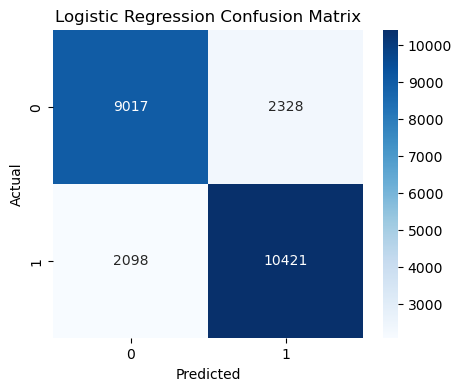

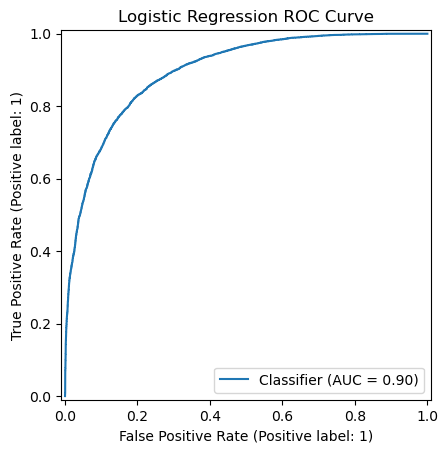


SVM Metrics
Train Accuracy: 0.8289
Test  Accuracy: 0.8262
F1 Score:      0.8395
Recall:        0.8681
ROC-AUC:       0.9102


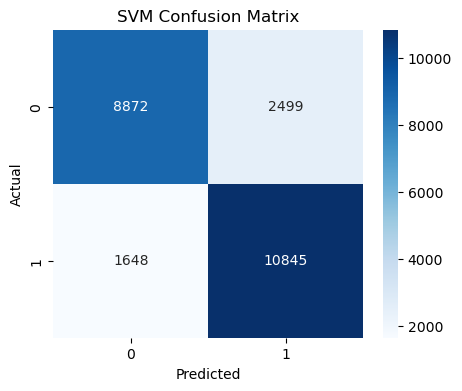

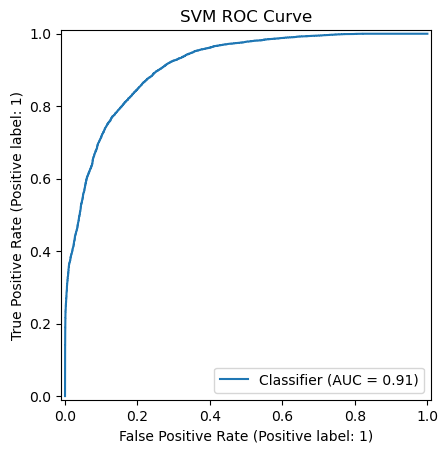


TabNet Metrics
Train Accuracy: 0.8465
Test  Accuracy: 0.8434
F1 Score:      0.8519
Recall:        0.8602
ROC-AUC:       0.9318


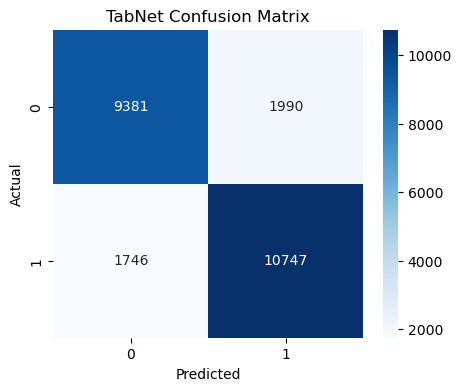

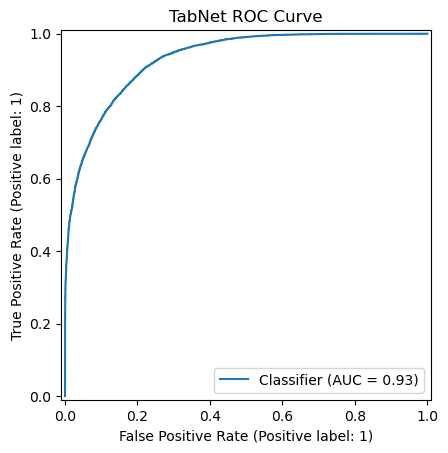

KeyError: 0

<Figure size 640x480 with 0 Axes>

In [107]:
# Logistc Regression
evaluate_model(
    "Logistic Regression",
    y_train, y_train_pred_lr, y_train_proba_lr,
    y_test,  y_test_pred_lr,  y_test_proba_lr
)

# SVM
evaluate_model(
    "SVM",
    y_train_tab, y_train_pred_svm, y_train_proba_svm,
    y_test_tab,  y_test_pred_svm,  y_test_proba_svm
)

# TabNet
evaluate_model(
    "TabNet",
    y_train_tab, pred_tab_train, pred_tab_train_proba,
    y_test_tab, pred_tab_test, pred_tab_test_proba,
    tabnet_model=clf
)




In [109]:
# Store metrics in a dictionary
model_metrics = {
    "Model": ["Logistic Regression", "TabNet", "SVM"],
    "Test Accuracy": [
        accuracy_score(y_test,     y_test_pred_lr),
        accuracy_score(y_test_tab, pred_tab_test),
        accuracy_score(y_test_tab, y_test_pred_svm)
    ],
    "F1 Score": [
        f1_score(y_test,     y_test_pred_lr),
        f1_score(y_test_tab, pred_tab_test),
        f1_score(y_test_tab, y_test_pred_svm)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test,     y_test_proba_lr),
        roc_auc_score(y_test_tab, pred_tab_test_proba),
        roc_auc_score(y_test_tab, y_test_proba_svm)
    ]
}

# Convert to DataFrame and round
metrics_df = pd.DataFrame(model_metrics)
metrics_df[["Test Accuracy","F1 Score","ROC-AUC"]] = metrics_df[["Test Accuracy","F1 Score","ROC-AUC"]].round(4)
metrics_df


,Model,Test Accuracy,F1 Score,ROC-AUC
0,Logistic Regression,0.8145,0.8248,0.8972
1,TabNet,0.8434,0.8519,0.9318
2,SVM,0.8262,0.8395,0.9102


<Figure size 800x500 with 0 Axes>

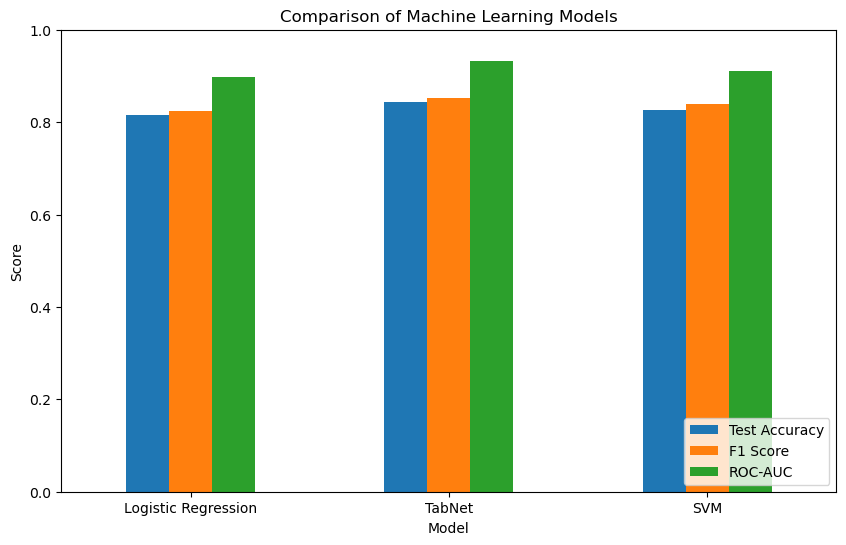

In [110]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(8,5))

# Plot bars
metrics_df.plot(x="Model", y=["Test Accuracy","F1 Score","ROC-AUC"], kind="bar", figsize=(10,6))
plt.title("Comparison of Machine Learning Models")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()


In [ ]:
delivery_df['city'].unique()

In [132]:
import pickle

In [133]:
pickle.dump(pipe, open('pipe.pkl', 'wb'))